In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle

from util import *
import scanpy.api as sc
import data_loader as dl
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
output_folder = './figures/figure_tradeoff_curve_simu_first_200'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
## Read subsample parameters
fname = './figures/figure_tradeoff_curve/data/subsample_param.pickle'
f_myfile = open(fname, 'rb')
B_sub_list = pickle.load(f_myfile)
subsample_param_dic = pickle.load(f_myfile)
f_myfile.close()

# Generate a nice toy example (from 4k)

In [4]:
data = dl.load_10x_4k()
gene_list = ['CD3D','CD3E','NKG7','GZMA'] # some marker genes 
mean_count = np.array(data.X.mean(axis=0)).reshape(-1)
sort_idx = np.argsort(mean_count)[::-1]
gene_list = list(data.var_names[sort_idx[0:200]])

Y = np.array(data[:,gene_list].X.todense()).astype(dtype=int)

p_true = np.ones([Y.shape[0]])
p_true = p_true / np.sum(p_true)
x_true = Y / np.sum(Y) * Y.shape[0]

mean_true = x_true.mean(axis=0)
var_true = x_true.var(axis=0)
cv_true = np.sqrt(var_true)/mean_true
cov_true = np.cov(x_true.T)
_,V_true = np.linalg.eigh(cov_true)
PC_true = np.corrcoef(x_true.T)
p0_true = np.mean(x_true==0,axis=0)
kappa = 10
p0_true_ub = np.mean(np.exp(-kappa*x_true),axis=0)
inactive_true = np.mean(np.exp(-kappa*x_true),axis=0)

##
p_dist_true_1d = np.bincount(Y[:,0])
p_dist_true_1d = p_dist_true_1d / np.sum(p_dist_true_1d)
x_dist_true_1d = np.arange(p_dist_true_1d.shape[0])

print('## cv_true',cv_true)
print('## PC_true')
print(PC_true)



Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## cv_true [ 0.45322517  0.79907628  0.53072199  0.53400089  0.62403003  0.58297793
  0.56209442  0.543008    0.52591689  0.57368849  0.58607094  0.67467482
  0.66958284  0.59615216  0.54481575  0.56060351  0.69868361  0.63169099
  1.19540231  0.57468631  0.63669735  0.83923536  0.55622353  0.57612555
  0.55274699  0.60621021  0.60689608  1.45583325  0.61481547  0.59013281
  0.75212861  0.65157726  0.5621434   0.61725963  0.60448576  0.65823376
  0.64708145  0.61096142  0.61583906  0.63395962  0.79524692  0.59728631
  0.67489657  0.59824452  0.83436223  0.69160529  0.5731258   2.11925557
  0.61216283  0.63006417  0.63789047  0.60056026  0.58546015  0.61910956
  0.62944812  0.66073737  1.32585602  0.68442069  0.62585659  0.75907681
  0.62194254  0.67504359  2.03811966  0.66059086  0.63310726  0.62066398
  0.63799091  0.6975365   0.82344602  0.67078566  2.23225273  0.63690676
  0.6706111   0.70951206  0.64

# Diagnosis

In [5]:
data,size_factor = dl.poi_data_gen_nd(p_true,x_true,Nr=500)

In [6]:
## cv 
M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)
print('## cv_true',cv_true)
print('## cv_ml',cv_ml)
print('## cv_dd',cv_dd)


## cv_true [ 0.45322517  0.79907628  0.53072199  0.53400089  0.62403003  0.58297793
  0.56209442  0.543008    0.52591689  0.57368849  0.58607094  0.67467482
  0.66958284  0.59615216  0.54481575  0.56060351  0.69868361  0.63169099
  1.19540231  0.57468631  0.63669735  0.83923536  0.55622353  0.57612555
  0.55274699  0.60621021  0.60689608  1.45583325  0.61481547  0.59013281
  0.75212861  0.65157726  0.5621434   0.61725963  0.60448576  0.65823376
  0.64708145  0.61096142  0.61583906  0.63395962  0.79524692  0.59728631
  0.67489657  0.59824452  0.83436223  0.69160529  0.5731258   2.11925557
  0.61216283  0.63006417  0.63789047  0.60056026  0.58546015  0.61910956
  0.62944812  0.66073737  1.32585602  0.68442069  0.62585659  0.75907681
  0.62194254  0.67504359  2.03811966  0.66059086  0.63310726  0.62066398
  0.63799091  0.6975365   0.82344602  0.67078566  2.23225273  0.63690676
  0.6706111   0.70951206  0.64261124  0.69239846  0.65683269  0.69703927
  0.71601716  0.65856183  0.58584186  0.

In [7]:
## PC and PCA estimation
mean_ml,cov_ml,PC_ml = sd.ml_covariance(data,size_factor=size_factor,verbose=False)
mean_dd,cov_dd,PC_dd = sd.dd_covariance(data,size_factor=size_factor,verbose=False)

print('## PC_true')
print(PC_true)

print('## PC_ml')
print(PC_ml)

print('## PC_dd')
print(PC_dd)

## PC_true
[[ 1.          0.17903239  0.63566101 ... -0.02693689  0.37582288
   0.04457846]
 [ 0.17903239  1.          0.21457113 ...  0.53618515  0.28717425
   0.68604311]
 [ 0.63566101  0.21457113  1.         ... -0.14396696  0.45936341
   0.10224994]
 ...
 [-0.02693689  0.53618515 -0.14396696 ...  1.          0.0507941
   0.4017185 ]
 [ 0.37582288  0.28717425  0.45936341 ...  0.0507941   1.
   0.19374737]
 [ 0.04457846  0.68604311  0.10224994 ...  0.4017185   0.19374737
   1.        ]]
## PC_ml
[[ 1.          0.16774619  0.52402917 ... -0.00427675  0.16714438
   0.03748713]
 [ 0.16774619  1.          0.17392085 ...  0.38811519  0.13651762
   0.44527838]
 [ 0.52402917  0.17392085  1.         ... -0.10118012  0.17995512
   0.06392313]
 ...
 [-0.00427675  0.38811519 -0.10118012 ...  1.          0.03642075
   0.22089958]
 [ 0.16714438  0.13651762  0.17995512 ...  0.03642075  1.
   0.07486791]
 [ 0.03748713  0.44527838  0.06392313 ...  0.22089958  0.07486791
   1.        ]]
## PC_dd
[[ 1

# Simulation on the toy 4k-pbmc example

In [ ]:
n_rep = 100
G = 200

test_list = ['cv','PC']

## use a two-layer dic to store the result
err_ml_dic = {}
err_dd_dic = {}

for test_type in test_list:
    err_ml_dic[test_type] = {}
    err_dd_dic[test_type] = {}

for B in subsample_param_dic.keys():
    for i in range(len(subsample_param_dic[B][0])):
        Nr_bar = subsample_param_dic[B][0][i]
        Nc = subsample_param_dic[B][1][i]
        Nr = Nr_bar*G
        key_ = '%d_%0.2f_%0.2f_%d'%(B,Nr_bar,Nr,Nc)
        
        for test_type in test_list:            
            err_ml_dic[test_type][key_] = []
            err_dd_dic[test_type][key_] = []
        for i_rep in range(n_rep):
            ## Data generation
            
            data,size_factor = dl.poi_data_gen_nd(p_true,x_true,Nc=Nc,Nr=Nr,random_seed=i_rep)
            
            ## cv 
            M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
            cv_ml = sd.M_to_cv(M_ml)
            cv_dd = sd.M_to_cv(M_dd)
            err_ml = np.log10(np.mean((cv_true-cv_ml)**2))
            err_dd = np.log10(np.mean((cv_true-cv_dd)**2))
            err_ml_dic['cv'][key_].append(err_ml)
            err_dd_dic['cv'][key_].append(err_dd)
            
            ## PC and PCA
            mean_ml,cov_ml,PC_ml = sd.ml_covariance(data,size_factor=size_factor,verbose=False)
            mean_dd,cov_dd,PC_dd = sd.dd_covariance(data,size_factor=size_factor,verbose=False,PC_prune=False)
            
            err_ml = np.log10(sd.d_PC(PC_true,PC_ml))
            err_dd = np.log10(sd.d_PC(PC_true,PC_dd))
            
            err_ml_dic['PC'][key_].append(err_ml)
            err_dd_dic['PC'][key_].append(err_dd)

## Save the data
fname = output_folder+'/data/tradeoff_error_statistics.pickle'
f_myfile = open(fname,'wb')
pickle.dump(err_ml_dic, f_myfile)
pickle.dump(err_dd_dic, f_myfile)
f_myfile.close()

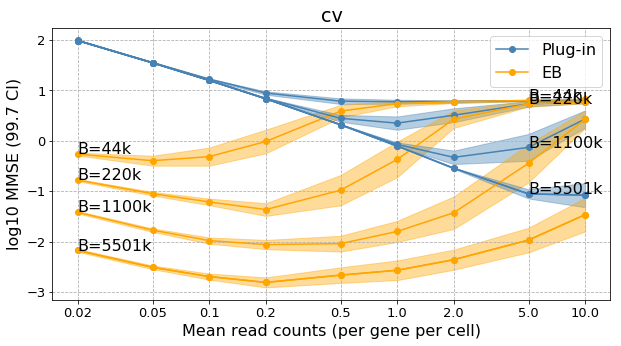

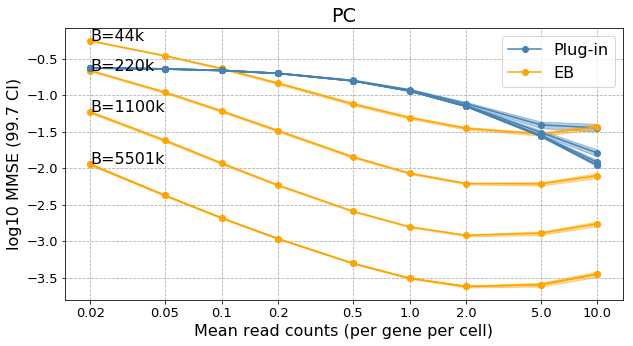

In [10]:
## Read data statistics 
fname = output_folder+'/data/tradeoff_error_statistics.pickle'
f_myfile = open(fname, 'rb')
error_ml_dic = pickle.load(f_myfile)
error_dd_dic = pickle.load(f_myfile)
f_myfile.close()

sd.plot_tradeoff_curve(err_ml_dic['cv'],err_dd_dic['cv'],output_folder=output_folder,suffix='cv',\
                       ylabel='log10 MMSE (99.7 CI)',title='cv',\
                      ann_ml=-2,ann_dd=0)

sd.plot_tradeoff_curve(err_ml_dic['PC'],err_dd_dic['PC'],output_folder=output_folder,suffix='PC',\
                       ylabel='log10 MMSE (99.7 CI)',title='PC',\
                      ann_ml=None,ann_dd=0)

# sd.plot_tradeoff_curve(err_ml_dic['PCA'],err_dd_dic['PCA'],output_folder=output_folder,suffix='PCA',\
#                        ylabel='log10 cosine distance (99.7 CI)',title='First principal component',\
#                       ann_ml=-2,ann_dd=0)

# sd.plot_tradeoff_curve(err_ml_dic['zero'],err_dd_dic['zero'],output_folder=output_folder,suffix='zero',\
#                        ylabel='log10 Robust error (kappa=10, 99.7 CI)',title='Inactive probability',\
#                       ann_ml=None,ann_dd=8)

# sd.plot_tradeoff_curve(err_ml_dic['dist'],err_dd_dic['dist'],output_folder=output_folder,suffix='dist',\
#                        ylabel='log10 W1 error (99.7 CI)',title='Distribution',\
#                       ann_ml=None,ann_dd=8)

# Simulation

In [11]:
import yellowbrick as yb

the toy true distribution


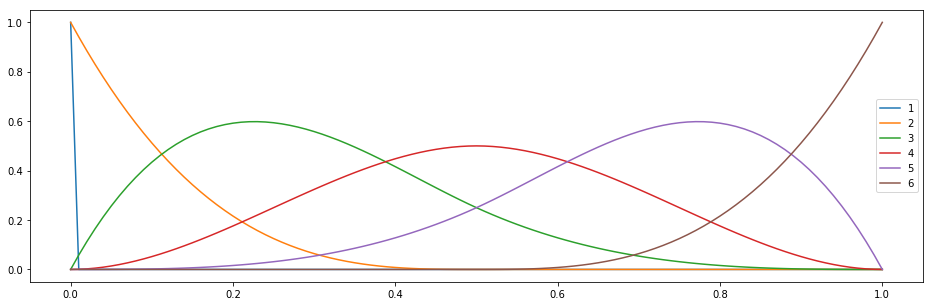

[ 3  2 -4  5 -2 -2]
--- ccdf ---
>0.05: 37.84%
>0.1: 36.09%
>0.15: 35.22%
>0.2: 34.57%
>0.25: 33.88%
>0.3: 32.97%
>0.35: 31.92%
>0.4: 29.37%


<Figure size 432x288 with 0 Axes>

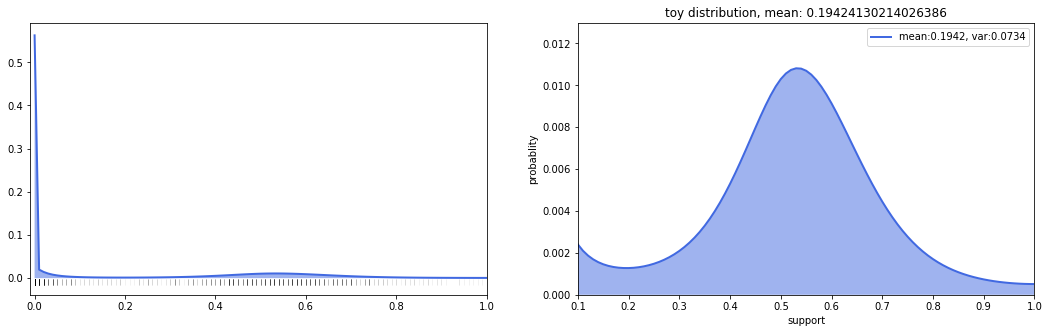

In [11]:
## creating a toy 1d distribution instance
print('the toy true distribution')
p,x_grid=dl.load_1d_toy_spline(verbose=True)

In [12]:
data,_,X = dl.poi_data_gen(p,x_grid,Nc=100000,Nr=10,require_X=True)
mean_X = np.mean(X,axis=0)
std_X = np.std(X,axis=0)
cv_X = std_X/mean_X

In [14]:
n_rep = 2
G = 2

error_cv_ml_dic = {}
error_cv_dd_dic = {}

error_dist_ml_dic = {}
error_dist_dd_dic = {}

for B in subsample_param_dic.keys():
    for i in range(len(subsample_param_dic[B][0])):
        Nr_bar = subsample_param_dic[B][0][i]
        Nc = subsample_param_dic[B][1][i]
        Nr = Nr_bar*G
        key_ = '%d_%0.1f_%0.1f_%d'%(B,Nr_bar,Nr,Nc)
        
        error_cv_ml_dic[key_] = []
        error_cv_dd_dic[key_] = []
        error_dist_ml_dic[key_] = []
        error_dist_dd_dic[key_] = []
        
        for i_rep in range(n_rep):
            data,size_factor = dl.poi_data_gen(p,x_grid,Nc=Nc,Nr=Nr,G=G)
            M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
            err_ml = np.log10(np.mean((cv_X - sd.M_to_cv(M_ml))**2))
            error_cv_ml_dic[key_].append(err_ml)
            err_dd = np.log10(np.mean((cv_X - sd.M_to_cv(M_dd))**2))
            error_cv_dd_dic[key_].append(err_dd)
            
            
            
            Y = np.array(data[:,0].X).reshape(-1).astype(int)
            p_ml = np.bincount(Y)
            p_ml = p_ml / p_ml.sum()
            x_ml = np.arange(p_ml.shape[0])            
            p_dd,x_dd = sd.dd_distribution(Y,gamma=None,verbose=False,c_reg=1e-6)
            
            mean_ml = p_ml.dot(x_ml)
            mean_dd = p_dd.dot(x_dd)
            mean_ = p.dot(x_grid)
            x_ml = x_ml * mean_ / mean_ml
            x_dd = x_dd * mean_ / mean_dd
            err_ml = np.log10(dist_W1(p,p_ml,x_grid,x_ml))
            err_dd = np.log10(dist_W1(p,p_dd,x_grid,x_dd))
            error_dist_ml_dic[key_].append(err_ml)
            error_dist_dd_dic[key_].append(err_dd)
            

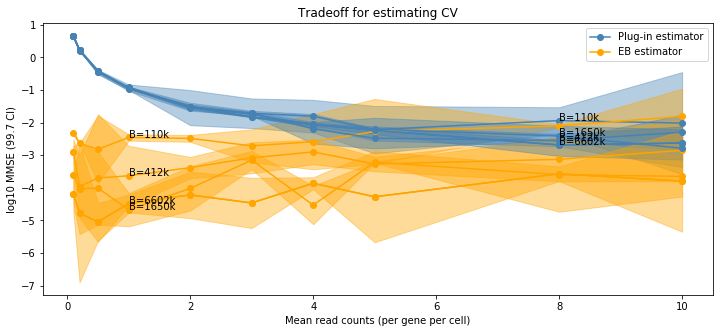

In [15]:
sd.plot_tradeoff_curve(error_cv_ml_dic,error_cv_dd_dic,output_folder=output_folder,suffix='cv_simu_',\
                       ylabel='log10 MMSE (99.7 CI)',title='Tradeoff for estimating CV',\
                      ann_ml=-2,ann_dd=3)

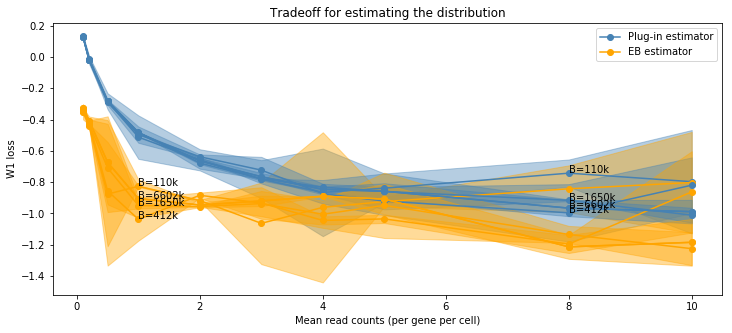

In [16]:
## Seems we need to generate the figure for distribution alone. 
## The scale is not quite the same 

sd.plot_tradeoff_curve(error_dist_ml_dic,error_dist_dd_dic,output_folder=output_folder,suffix='cv_simu_',\
                       ylabel='W1 loss',title='Tradeoff for estimating the distribution',\
                      ann_ml=-2,ann_dd=3)

# Old code

In [ ]:
rep_time = 10

subsample_folder = '/data/martin/exp_sceb/subsample_1.3mil/subsampled_data_small'
filename_list = os.listdir(subsample_folder)

## collect the estimation error 
error_cv_ml_dic = {}
error_cv_dd_dic = {}
error_zero_ml_dic = {}
error_zero_dd_dic = {}
error_dist_ml_dic = {}
error_dist_dd_dic = {}

## Initialization
for fname in filename_list:
    key_ = fname_to_key(fname)
    error_cv_ml_dic[key_] = []
    error_cv_dd_dic[key_] = []
    error_PCA_ml_dic[key_] = []
    error_PCA_dd_dic[key_] = []
    error_zero_ml_dic[key_] = []
    error_zero_dd_dic[key_] = []
    
for fname in filename_list:
    print(fname)
    data = sc.read(subsample_folder+'/'+fname)
    key_ = fname_to_key(fname)
    
    ## CV estimation
    M_ml,M_dd = sd.dd_1d_moment(data,verbose=False)
    err_ml = np.log10(np.mean((cv_full - sd.M_to_cv(M_ml))**2))
    error_cv_ml_dic[key_].append(err_ml)
    err_dd = np.log10(np.mean((cv_full - sd.M_to_cv(M_dd))**2))
    error_cv_dd_dic[key_].append(err_dd)
    
    ## Pearson correlation estimation and PCA direction estimation
    mean_dd_full,cov_dd,PC_dd = sd.dd_covariance(data)
    mean_ml_full,cov_ml,PC_ml = sd.ml_covariance(data) 
    err_ml = np.log10(np.mean((PC_ml_full - PC_ml)**2))
    error_PC_ml_dic[key_].append(err_ml)
    err_dd = np.log10(np.mean((PC_ml_full - PC_dd)**2))
    error_PC_dd_dic[key_].append(err_dd)
    
    ## PCA direction estimation
    _,V_ml = np.linalg.eigh(cov_ml)
    _,V_ml = np.linalg.eigh(cov_dd)
    err_ml = np.log10(np.mean((V_full[:,-1]-V_ml[:,-1])**2))
    error_PC_ml_dic[key_].append(err_ml)
    err_dd = np.log10(np.mean((V_full[:,-1]-V_dd[:,-1])**2))
    error_PC_dd_dic[key_].append(err_dd)
    
    ## Zero probability estimation

In [137]:
subsample_folder = '/data/martin/exp_sceb/subsample_1.3mil/subsampled_data_small'
filename_list = os.listdir(subsample_folder)

## collect the estimation error 
error_cv_ml_dic = {}
error_cv_dd_dic = {}
error_PC_ml_dic = {}
error_PC_dd_dic = {}
error_PCA_ml_dic = {}
error_PCA_dd_dic = {}
error_zero_ml_dic = {}
error_zero_dd_dic = {}

## Initialization
for fname in filename_list:
    key_ = fname_to_key(fname)
    error_cv_ml_dic[key_] = []
    error_cv_dd_dic[key_] = []
    error_PC_ml_dic[key_] = []
    error_PC_dd_dic[key_] = []
    error_PCA_ml_dic[key_] = []
    error_PCA_dd_dic[key_] = []
    error_zero_ml_dic[key_] = []
    error_zero_dd_dic[key_] = []
    
for fname in filename_list:
    print(fname)
    data = sc.read(subsample_folder+'/'+fname)
    key_ = fname_to_key(fname)
    
    ## CV estimation
    M_ml,M_dd = sd.dd_1d_moment(data,verbose=False)
    err_ml = np.log10(np.mean((cv_full - sd.M_to_cv(M_ml))**2))
    error_cv_ml_dic[key_].append(err_ml)
    err_dd = np.log10(np.mean((cv_full - sd.M_to_cv(M_dd))**2))
    error_cv_dd_dic[key_].append(err_dd)
    
    ## Pearson correlation estimation and PCA direction estimation
    mean_dd_full,cov_dd,PC_dd = sd.dd_covariance(data)
    mean_ml_full,cov_ml,PC_ml = sd.ml_covariance(data) 
    err_ml = np.log10(np.mean((PC_ml_full - PC_ml)**2))
    error_PC_ml_dic[key_].append(err_ml)
    err_dd = np.log10(np.mean((PC_ml_full - PC_dd)**2))
    error_PC_dd_dic[key_].append(err_dd)
    
    ## PCA direction estimation
    _,V_ml = np.linalg.eigh(cov_ml)
    _,V_ml = np.linalg.eigh(cov_dd)
    err_ml = np.log10(np.mean((V_full[:,-1]-V_ml[:,-1])**2))
    error_PC_ml_dic[key_].append(err_ml)
    err_dd = np.log10(np.mean((V_full[:,-1]-V_dd[:,-1])**2))
    error_PC_dd_dic[key_].append(err_dd)
    
    ## Zero probability estimation

NameError: name 'filename_list' is not defined

# Generating the plots